In [1]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls drive/MyDrive/"Colab Notebooks"/data/

hlm_df.csv             submission.csv    train.csv
mlm_df.csv             test.csv          train_fps_mol.csv
preprocessed_data.csv  test_fps_mol.csv
sample_submission.csv  test_smile.csv


In [3]:
path =  "drive/MyDrive/Colab Notebooks/data/"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [5]:
sns.set_style('whitegrid')

In [6]:
df_ = pd.read_csv(path + 'preprocessed_data.csv')
df_.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [7]:
df_.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         2
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [7]:
idx_null = df_[df_['AlogP'].isnull()].index
idx_null

Int64Index([2788, 3377], dtype='int64')

In [8]:
df_ = df_.drop(idx_null, axis=0)
df_.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [9]:
df_['mol'] = df_['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_['mol'] = df_['mol'].apply(lambda x: Chem.AddHs(x))
df_['num_of_atoms'] = df_['mol'].apply(lambda x: x.GetNumAtoms())
df_['num_of_heavy_atoms'] = df_['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [12]:
df_.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,mol,num_of_atoms,num_of_heavy_atoms
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,<rdkit.Chem.rdchem.Mol object at 0x79dcdf6a05f0>,52,28
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,<rdkit.Chem.rdchem.Mol object at 0x79dcdf6a0660>,40,21
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,<rdkit.Chem.rdchem.Mol object at 0x79dcdf6a06d0>,41,22
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,<rdkit.Chem.rdchem.Mol object at 0x79dcdf6a0740>,69,35
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,<rdkit.Chem.rdchem.Mol object at 0x79dcdf6a07b0>,36,20


In [10]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')
# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df_['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (3,), (4,), (5,), (6,), (7,), (9,), (11,), (12,), (13,), (14,), (16,), (17,), (19,), (20,), (23,), (24,), (26,), (27,))


In [11]:
# 임의의 패턴(원자)를 몇개 포함하고 있는지를 얻는 함수
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df_)

# AlogP 분리 시키기

In [15]:
df_.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'mol', 'num_of_atoms',
       'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')

In [16]:
len(df_.columns)

18

In [12]:
x_columns = ['Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms','num_of_N_atoms', 'num_of_Cl_atoms']
y_columns = 'AlogP'

In [13]:
len(x_columns)

12

In [14]:
x = df_[x_columns]
y = df_[y_columns].values

In [15]:
x.shape, y.shape

((3485, 12), (3485,))

# Split

In [78]:
######################################################################
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2788, 12), (697, 12), (2788,), (697,))

# RMSE + 그래프

In [18]:
def show_reg_result(y_test, y_pred, N=50):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f' AlogP의 RMSE:', round(rmse, 4))
    print(f' AlogP의 RMSE * 0.5 :', round(rmse * 0.5, 4))

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel("AlogP")
      plt.show()

# Max_Depth 몇으로 할까?

In [19]:
def find_max_depth(X_train, X_test, y_train, y_test):
    for depth in range(1,20):
        dtr = DecisionTreeRegressor(max_depth=depth)
        dtr.fit(X_train, y_train)
        print(depth, dtr.score(X_test, y_test).round(3))

In [20]:
find_max_depth(X_train, X_test, y_train, y_test)
# 5 : 0.909

1 0.597
2 0.804
3 0.882
4 0.904
5 0.907
6 0.903
7 0.898
8 0.898
9 0.888
10 0.885
11 0.883
12 0.88
13 0.876
14 0.866
15 0.864
16 0.864
17 0.859
18 0.865
19 0.859


# AlogP 구해보기.

 AlogP의 RMSE: 0.5012
 AlogP의 RMSE * 0.5 : 0.2506


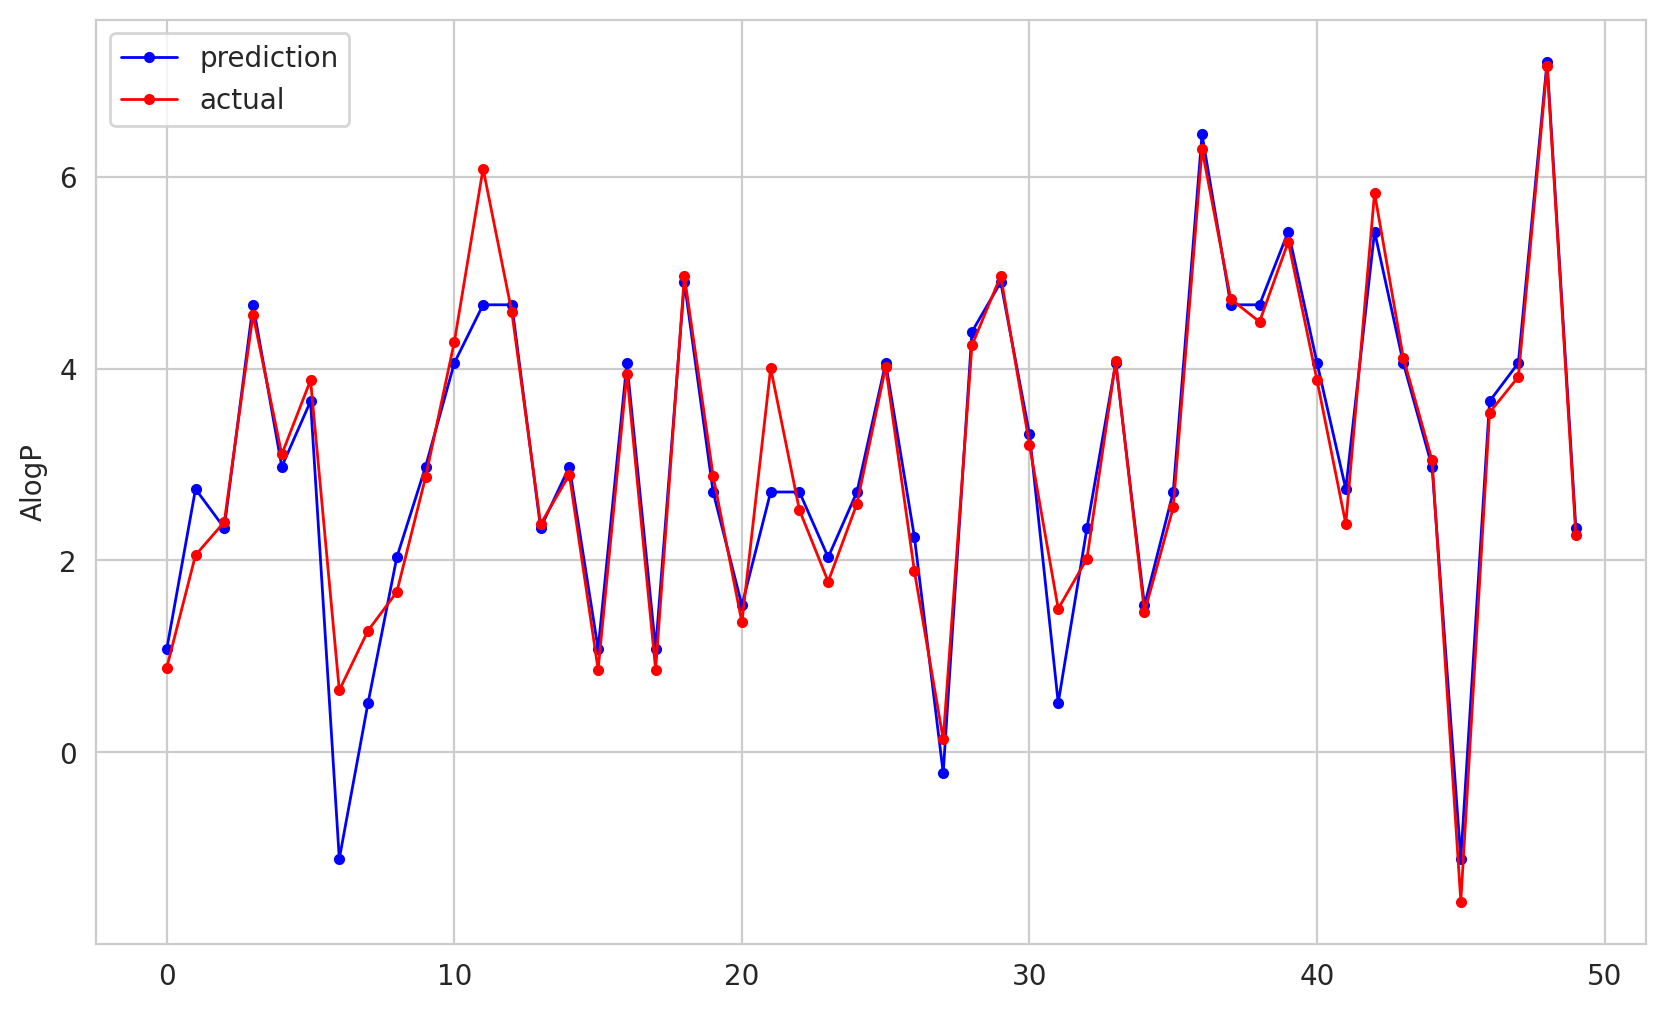

In [79]:
######################################################################
# 결정 트리 회귀 모델
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
show_reg_result(y_test, y_pred)

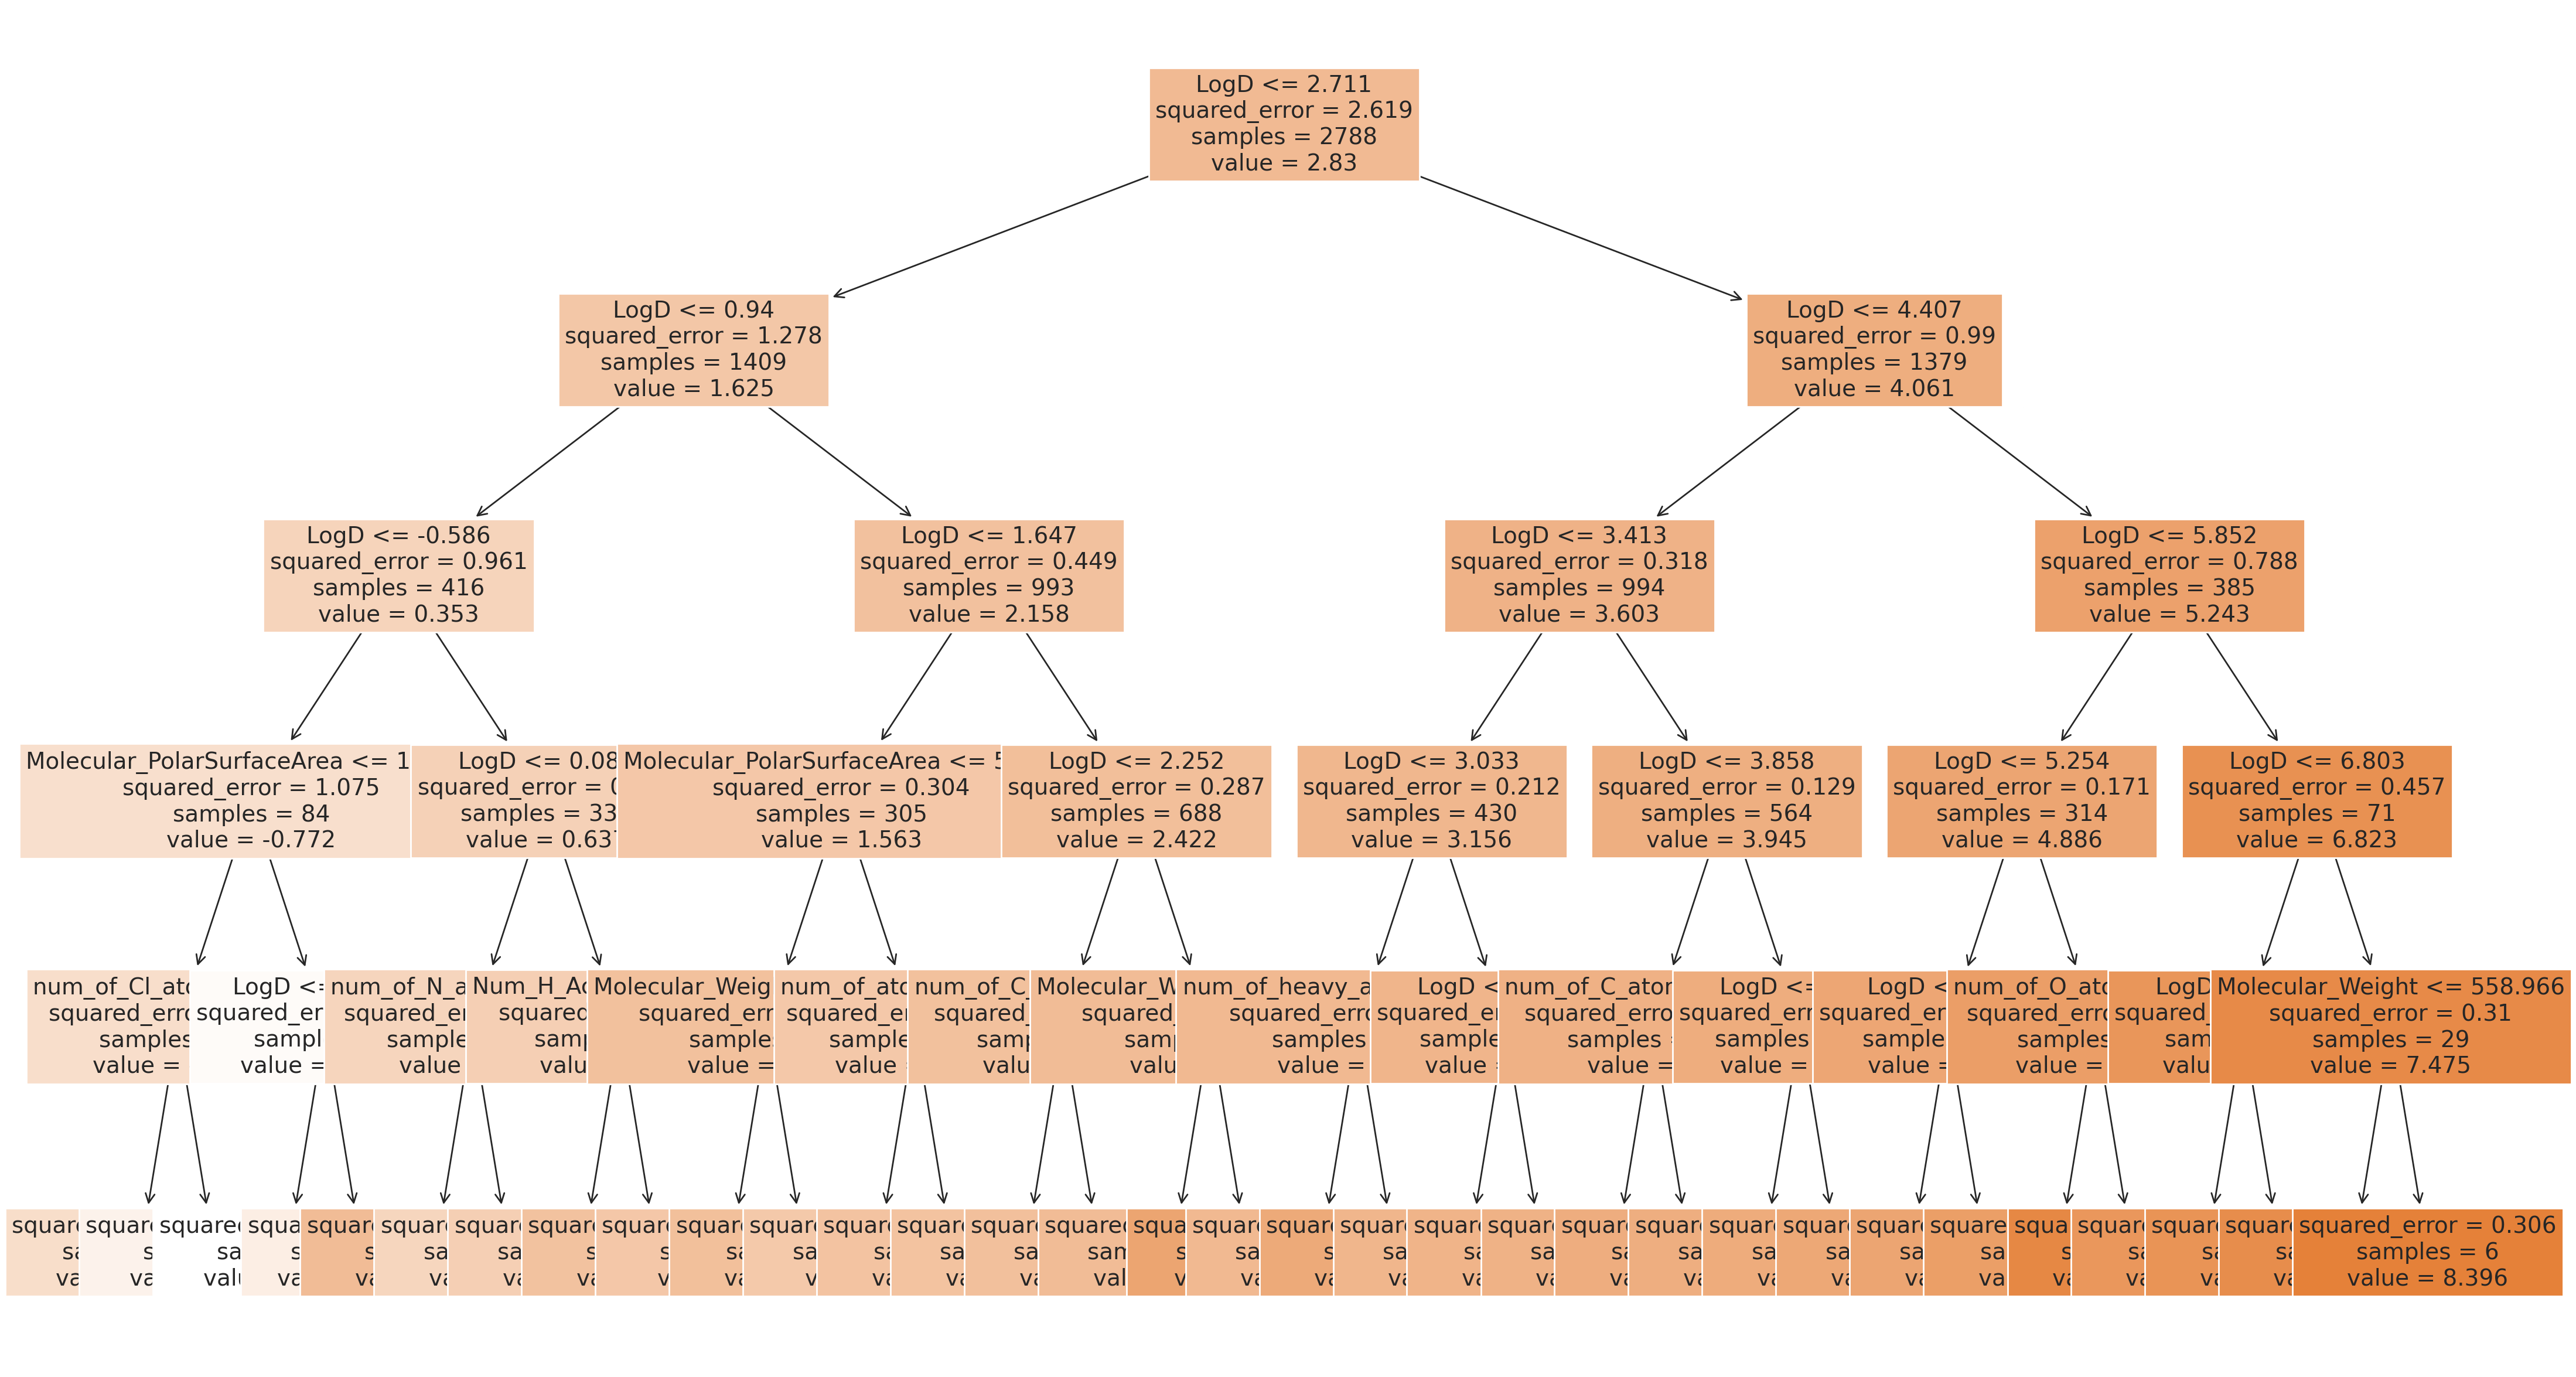

In [26]:
from sklearn import tree
plt.figure(figsize=(26, 15))

tree.plot_tree(dtr, fontsize=14,
              feature_names=X_train.columns,
              filled=True,
              impurity=True,
              max_depth=5)
plt.show()

 AlogP의 RMSE: 0.4383
 AlogP의 RMSE * 0.5 : 0.2191


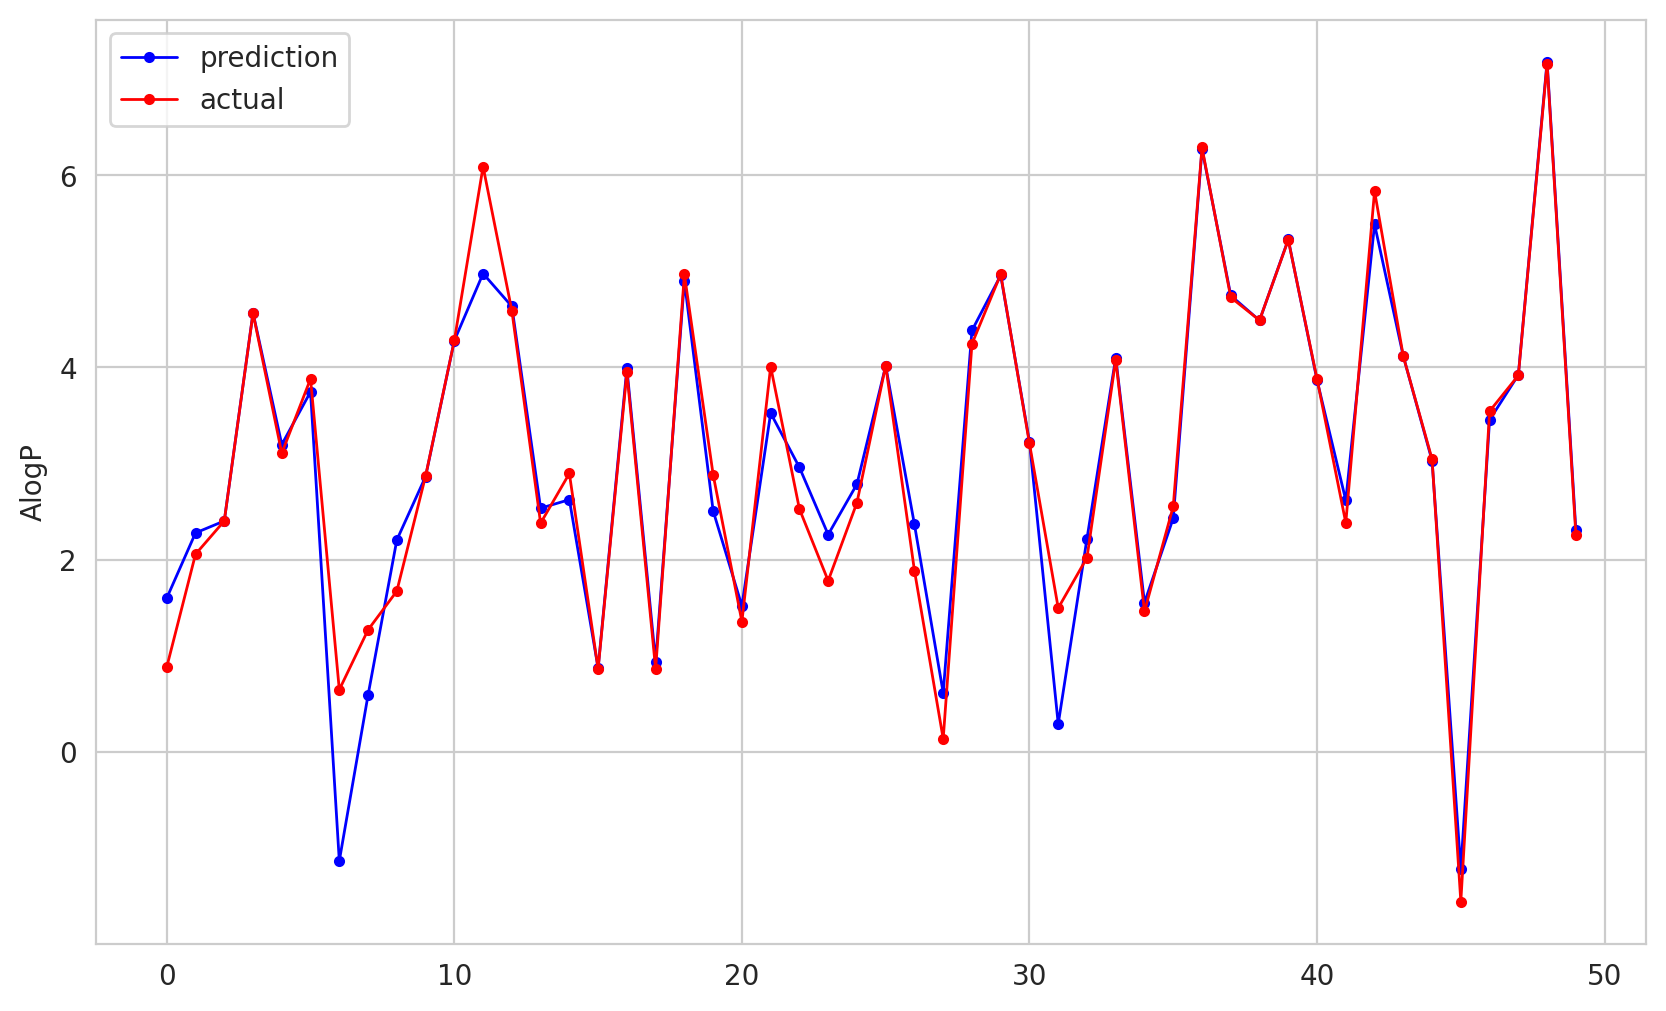

In [81]:
######################################################################
rfr = RandomForestRegressor(max_depth=15)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test, y_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 2788, number of used features: 12
[LightGBM] [Info] Start training from score 2.845137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

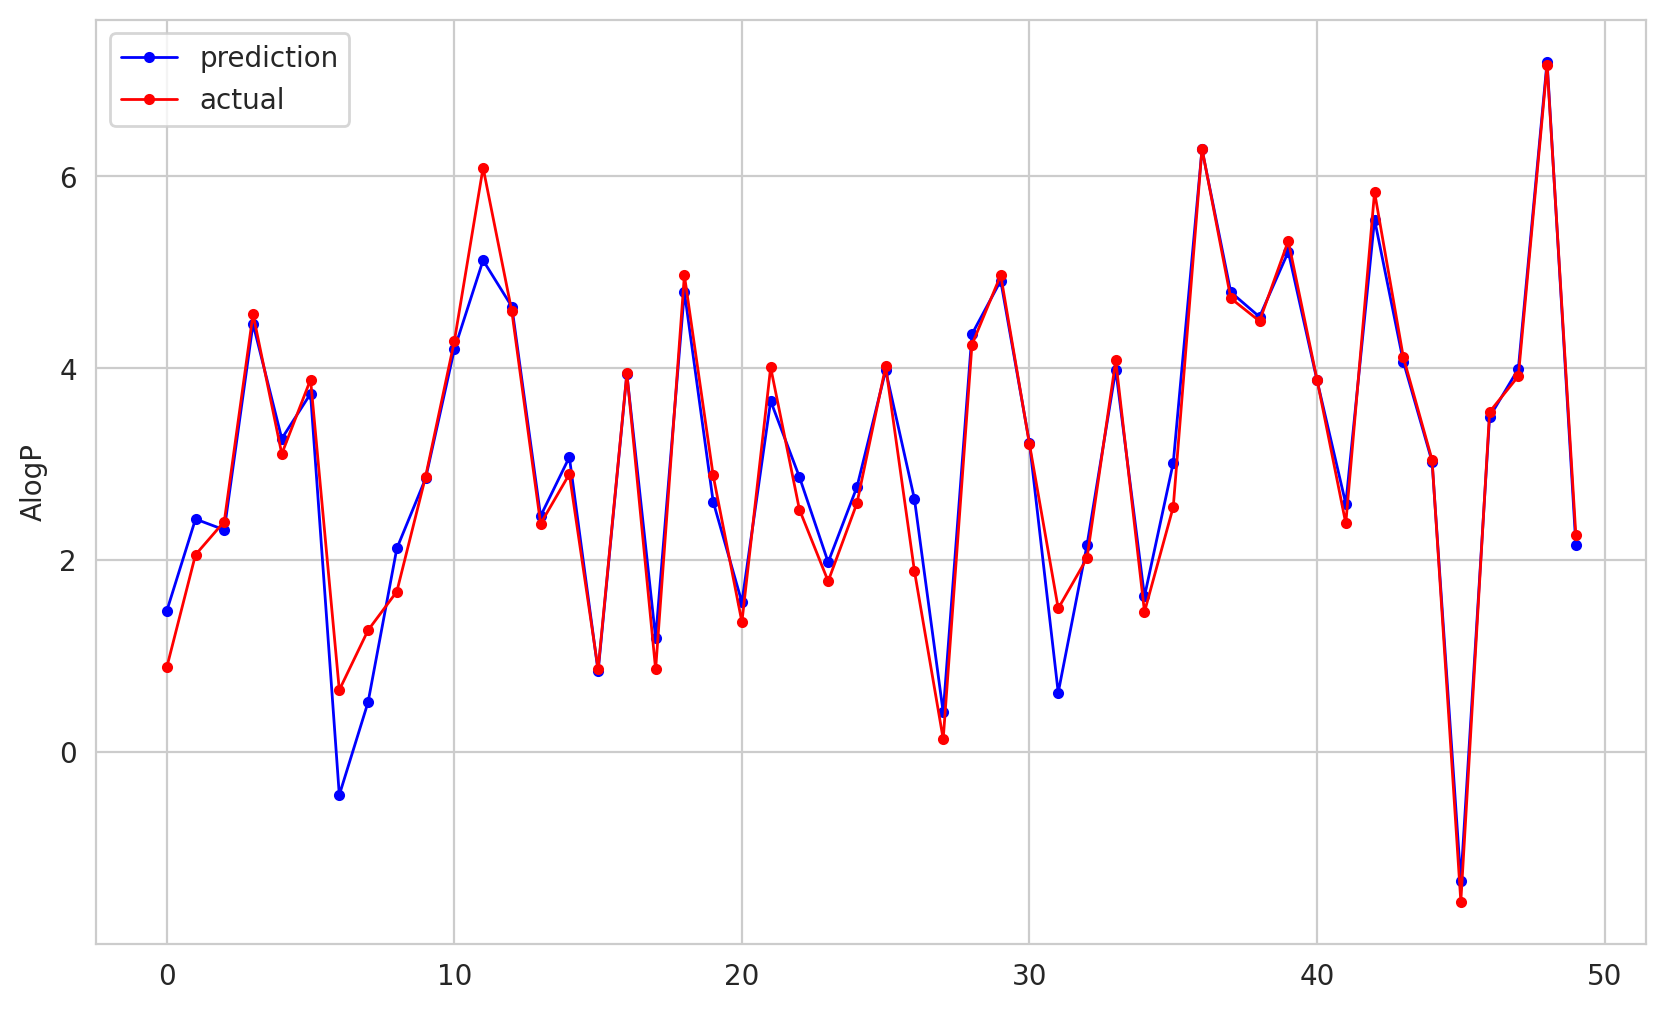

In [82]:
######################################################################
lgbm_r = LGBMRegressor(max_depth=5)
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test, y_pred)

# null 값 채우기

In [107]:
df = pd.read_csv(path + 'preprocessed_data.csv')

In [28]:
df.loc[idx_null]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2788,TRAIN_2796,[H][C@]1(CC[C@@]2([H])[C@@H](C)C=CC3=C[C@H](C)...,0.549,0.2,NaN,418.566,5,1,7,4.634,72.83
3377,TRAIN_3387,COc1cc2c(cc1OC)/C(=N\c1ccccc1)N(Cc1ccccc1F)CC2,0.240,3.2,NaN,390.450,3,0,5,4.911,34.06


In [29]:
df_null = df.loc[idx_null]

In [30]:
df_null['mol'] = df_null['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_null['mol'] = df_null['mol'].apply(lambda x: Chem.AddHs(x))
df_null['num_of_atoms'] = df_null['mol'].apply(lambda x: x.GetNumAtoms())
df_null['num_of_heavy_atoms'] = df_null['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [31]:
number_of_atoms(['C','O', 'N', 'Cl'], df_null)

In [32]:
df_null

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
2788,TRAIN_2796,[H][C@]1(CC[C@@]2([H])[C@@H](C)C=CC3=C[C@H](C)...,0.549,0.2,NaN,418.566,5,1,7,4.634,72.83,<rdkit.Chem.rdchem.Mol object at 0x7d0550e4be60>,68,30,25,5,0,0
3377,TRAIN_3387,COc1cc2c(cc1OC)/C(=N\c1ccccc1)N(Cc1ccccc1F)CC2,0.240,3.2,NaN,390.450,3,0,5,4.911,34.06,<rdkit.Chem.rdchem.Mol object at 0x7d0550e4bed0>,52,29,24,2,2,0


In [33]:
temp = df_null[x_columns]

In [43]:
alop_list1 = []
alop_list2 = []

In [83]:
######################################################################
for i in range(len(temp)):
    print('-----' * 5)
    print(f'index : {temp.index[i]}')
    print('-----' * 5)
    print(f"decision tree의 AlogP : {dtr.predict(temp.iloc[[i]])}")
    print(f"random forest의 AlogP : {rfr.predict(temp.iloc[[i]])}")
    print(f"lightgbm의　AlogP : {lgbm_r.predict(temp.iloc[[i]])}")

    if i == 0:
        alop_list1.append(dtr.predict(temp.iloc[[i]]))
        alop_list1.append(rfr.predict(temp.iloc[[i]]))
        alop_list1.append(lgbm_r.predict(temp.iloc[[i]]))
    else:
        alop_list2.append(dtr.predict(temp.iloc[[i]]))
        alop_list2.append(rfr.predict(temp.iloc[[i]]))
        alop_list2.append(lgbm_r.predict(temp.iloc[[i]]))

-------------------------
index : 2788
-------------------------
decision tree의 AlogP : [4.66665152]
random forest의 AlogP : [4.68580233]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lightgbm의　AlogP : [4.66437394]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
-------------------------
index : 3377
-------------------------
decision tree의 AlogP : [4.90260656]
random forest의 AlogP : [4.79750715]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lightgbm의　AlogP : [4.895477]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [84]:
alop_list1, alop_list2

([array([4.60359016]),
  array([4.68231983]),
  array([4.69181691]),
  array([4.56201974]),
  array([4.67999946]),
  array([4.8023132]),
  array([4.6012795]),
  array([4.6775005]),
  array([4.67372927]),
  array([4.57192949]),
  array([4.70309694]),
  array([4.6643199]),
  array([4.66665152]),
  array([4.68580233]),
  array([4.66437394])],
 [array([4.89463889]),
  array([4.89571932]),
  array([5.02071945]),
  array([4.88079333]),
  array([4.85331343]),
  array([5.05022853]),
  array([4.90208661]),
  array([4.81299403]),
  array([4.90457657]),
  array([4.87675177]),
  array([4.86932709]),
  array([5.07650801]),
  array([4.90260656]),
  array([4.79750715]),
  array([4.895477])])

In [90]:
len(alop_list1), len(alop_list2), np.mean(alop_list1), np.mean(alop_list2)

(15, 15, 4.662049512288267, 4.908883182796739)

In [89]:
np.mean(alop_list1)
np.mean(alop_list2)

4.662049512288267

In [96]:
idx_null[0]

2788

In [108]:
df.loc[idx_null[0], 'AlogP'] = np.mean(alop_list1)
df.loc[idx_null[1], 'AlogP'] = np.mean(alop_list2)

In [109]:
df.loc[idx_null]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2788,TRAIN_2796,[H][C@]1(CC[C@@]2([H])[C@@H](C)C=CC3=C[C@H](C)...,0.549,0.2,4.662050,418.566,5,1,7,4.634,72.83
3377,TRAIN_3387,COc1cc2c(cc1OC)/C(=N\c1ccccc1)N(Cc1ccccc1F)CC2,0.240,3.2,4.908883,390.450,3,0,5,4.911,34.06


In [110]:
df.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3487 non-null   object 
 1   SMILES                      3487 non-null   object 
 2   MLM                         3487 non-null   float64
 3   HLM                         3487 non-null   float64
 4   AlogP                       3487 non-null   float64
 5   Molecular_Weight            3487 non-null   float64
 6   Num_H_Acceptors             3487 non-null   int64  
 7   Num_H_Donors                3487 non-null   int64  
 8   Num_RotatableBonds          3487 non-null   int64  
 9   LogD                        3487 non-null   float64
 10  Molecular_PolarSurfaceArea  3487 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 299.8+ KB


In [112]:
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [ ]:
df

In [120]:
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [121]:
number_of_atoms(['C','O', 'N', 'Cl'], df)

# Test Dataframe의 AlogP 채우기

In [37]:
test_df = pd.read_csv(path + 'test.csv')

In [38]:
test_df['mol'] = test_df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
test_df['mol'] = test_df['mol'].apply(lambda x: Chem.AddHs(x))
test_df['num_of_atoms'] = test_df['mol'].apply(lambda x: x.GetNumAtoms())
test_df['num_of_heavy_atoms'] = test_df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [39]:
number_of_atoms(['C','O', 'N', 'Cl'], test_df)

In [40]:
idx_t_null = test_df[test_df['AlogP'].isnull()].index
# Int64Index([10], dtype='int64')

In [42]:
test_df.loc[idx_t_null][x_columns]

,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
10,404.412,6,1,4,3.942,74.22,50,30,24,6,0,0


In [48]:
temp_t = test_df.loc[idx_t_null][x_columns]

In [47]:
alop_list_t = []

In [85]:
######################################################################
for i in range(len(temp_t)):
    print('-----' * 5)
    print(f'index : {temp_t.index[i]}')
    print('-----' * 5)
    print(f"decision tree의 AlogP : {dtr.predict(temp_t.iloc[[i]])}")
    print(f"random forest의 AlogP : {rfr.predict(temp_t.iloc[[i]])}")
    print(f"lightgbm의　AlogP : {lgbm_r.predict(temp_t.iloc[[i]])}")

    alop_list_t.append(dtr.predict(temp_t.iloc[[i]]))
    alop_list_t.append(rfr.predict(temp_t.iloc[[i]]))
    alop_list_t.append(lgbm_r.predict(temp_t.iloc[[i]]))

-------------------------
index : 10
-------------------------
decision tree의 AlogP : [4.05971375]
random forest의 AlogP : [3.95423392]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lightgbm의　AlogP : [3.97909227]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [86]:
alop_list_t

[array([4.02243976]),
 array([3.94515983]),
 array([4.03295622]),
 array([4.0975]),
 array([3.96205099]),
 array([4.04402787]),
 array([4.09833882]),
 array([3.95858528]),
 array([3.98552937]),
 array([4.10366296]),
 array([3.970111]),
 array([3.99389746]),
 array([4.05971375]),
 array([3.95423392]),
 array([3.97909227])]

In [113]:
np.mean(alop_list_t)

4.013819966386605

In [114]:
test_df.loc[idx_t_null, 'AlogP'] = np.mean(alop_list_t)

In [118]:
test_df.isnull().sum()

id                            0
SMILES                        0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
mol                           0
num_of_atoms                  0
num_of_heavy_atoms            0
num_of_C_atoms                0
num_of_O_atoms                0
num_of_N_atoms                0
num_of_Cl_atoms               0
dtype: int64

In [119]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          483 non-null    object 
 1   SMILES                      483 non-null    object 
 2   AlogP                       483 non-null    float64
 3   Molecular_Weight            483 non-null    float64
 4   Num_H_Acceptors             483 non-null    int64  
 5   Num_H_Donors                483 non-null    int64  
 6   Num_RotatableBonds          483 non-null    int64  
 7   LogD                        483 non-null    float64
 8   Molecular_PolarSurfaceArea  483 non-null    float64
 9   mol                         483 non-null    object 
 10  num_of_atoms                483 non-null    int64  
 11  num_of_heavy_atoms          483 non-null    int64  
 12  num_of_C_atoms              483 non-null    int64  
 13  num_of_O_atoms              483 non

In [117]:
test_df.loc[idx_t_null]

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
10,TEST_010,[H]C1(C(O)c2ccc3c(c2)OCO3)C(=O)Oc2cc(OC)ccc2C1...,4.01382,404.412,6,1,4,3.942,74.22,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8d150>,50,30,24,6,0,0


In [115]:
test_df.head()

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8ccf0>,52,25,18,1,5,0
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8cd60>,49,27,20,5,2,0
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8cdd0>,47,26,20,1,5,0
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8ce40>,41,26,18,1,7,0
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15,<rdkit.Chem.rdchem.Mol object at 0x7d0550e8ceb0>,49,26,19,2,5,0


# csv로 저장

In [123]:
test_df.to_csv(path + 'preprocessed_test.csv', index=False, encoding='utf-8-sig')

In [124]:
df.to_csv(path + 'preprocessed_train.csv', index=False, encoding='utf-8-sig')

# Double check

In [125]:
pd.read_csv(path + 'preprocessed_test.csv').isnull().sum()

id                            0
SMILES                        0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
mol                           0
num_of_atoms                  0
num_of_heavy_atoms            0
num_of_C_atoms                0
num_of_O_atoms                0
num_of_N_atoms                0
num_of_Cl_atoms               0
dtype: int64

In [126]:
pd.read_csv(path + 'preprocessed_train.csv').isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
mol                           0
num_of_atoms                  0
num_of_heavy_atoms            0
num_of_C_atoms                0
num_of_O_atoms                0
num_of_N_atoms                0
num_of_Cl_atoms               0
dtype: int64